- maybe cluster avec en x l'angle et en y la dist du snout à la tailbase
- mettre autre méthode de corruption
- rajouter max du random ds méthode de corruption

In [108]:
import numpy as np
import pandas as pd
import math
import re
import deeplabcut
from sklearn.cluster import DBSCAN
from collections import Counter
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from pylab import rcParams

rcParams['figure.figsize'] = 14, 6
%matplotlib inline

In [109]:
path = 'openfield-Pranav-2018-08-20'
original = f'{path}/labeled-data-correct/m1s1/CollectedData_Pranav.csv'
target_csv = f'{path}/labeled-data/m1s1/CollectedData_Pranav.csv'
target_h5 = f'{path}/labeled-data/m1s1/CollectedData_Pranav.h5'

path_config_file = f'{path}/config.yaml'
# read the configure file - config.yaml
cfg = deeplabcut.auxiliaryfunctions.read_config(path_config_file)
# get the scorer name / bodyparts
scorer = cfg['scorer']
bodyparts = cfg['bodyparts']

In [110]:
from FunctionsLib import distance_keypoints,clean_dataset
df = pd.read_hdf(r'openfield-Pranav-2018-08-20\labeled-data\m1s1\CollectedData_Pranav.h5')
dist = distance_keypoints(df,'snout','tailbase')

# check if there are any NaN values
nan_rows = df[df.isna().any(axis=1)]
print(nan_rows)

data = pd.DataFrame(data=dist, index=df.index, columns=None)

data = clean_dataset(data)
#df.plot()

scorer                          Pranav                                    \
bodyparts                        snout          leftear         rightear   
coords                               x       y        x       y        x   
labeled-data/m1s1/img0109.png  266.333  59.667  269.667  71.000    279.0   
labeled-data/m1s1/img0110.png  317.667  72.000  330.333  51.667      NaN   

scorer                                                
bodyparts                             tailbase        
coords                              y        x     y  
labeled-data/m1s1/img0109.png  53.333      NaN   NaN  
labeled-data/m1s1/img0110.png     NaN    313.0  58.0  


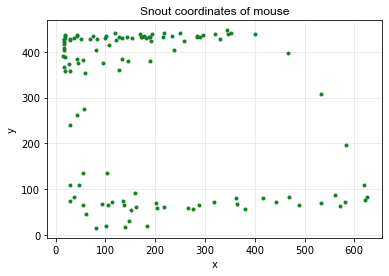

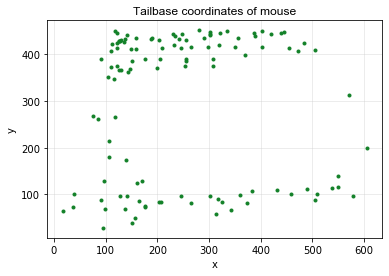

In [111]:
# plotting x and y coordinates of snout and tailbase
# snout
_ = plt.plot(df.loc[:][(scorer,bodyparts[0],'x')],df.loc[:][(scorer,bodyparts[0], 'y')],marker='.',linewidth=0, color='#128128')
_ = plt.grid(which='major',color='#cccccc', alpha = 0.45)
_ = plt.title('Snout coordinates of mouse', family='Arial', fontsize=12)
_ = plt.xlabel('x')
_ = plt.ylabel('y')
_ = plt.show()

# tailbase
__ = plt.plot(df.loc[:][(scorer,bodyparts[3],'x')],df.loc[:][(scorer,bodyparts[3], 'y')],marker='.',linewidth=0, color='#128128')
__ = plt.grid(which='major',color='#cccccc', alpha = 0.45)
__ = plt.title('Tailbase coordinates of mouse', family='Arial', fontsize=12)
__ = plt.xlabel('x')
__ = plt.ylabel('y')
__ = plt.show()

#### DBSCAN clustering algorithm

In [112]:
# Prepare data for model
dbscan_data = data
dbscan_data = dbscan_data.values.astype('float32')

# Normalize data
dbscan_data_scaler = StandardScaler().fit(dbscan_data)
dbscan_data = dbscan_data_scaler.transform(dbscan_data)

# Construct model
model = DBSCAN(eps=0.25,min_samples=10,metric='euclidean').fit(dbscan_data)
model

DBSCAN(eps=0.25, min_samples=10)

In [113]:
# Separate outliers from clustered data
outliers_df = data[model.labels_==-1]
clusters_df = data[model.labels_!=-1]

colors = model.labels_
colors_clusters = colors[colors != -1]
color_outliers = 'black'

# Get info abuot the clusters
clusters = Counter(model.labels_)
print(clusters)
print(data[model.labels_ == -1].head())
print('Number of clusters = {}'.format(len(clusters)-1))

Counter({0: 99, -1: 16})
                                        0
labeled-data/m1s1/img0022.png   80.267010
labeled-data/m1s1/img0023.png   78.537020
labeled-data/m1s1/img0026.png   51.565772
labeled-data/m1s1/img0058.png  155.683007
labeled-data/m1s1/img0061.png   62.189674
Number of clusters = 1


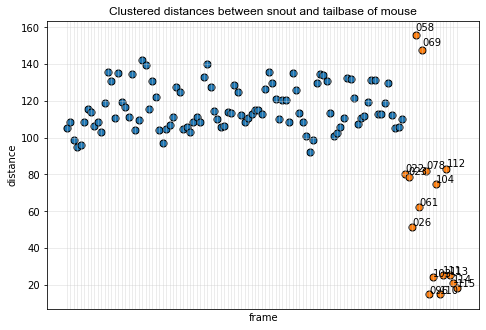

In [114]:
# Plot clusters and outliers
fig = plt.figure()

ax = fig.add_axes([.1,.1,1,1])

ax.scatter(clusters_df.index,clusters_df, edgecolors='black',s=50)
ax.scatter(outliers_df.index,outliers_df, edgecolors='black',s=50)

plt.title('Clustered distances between snout and tailbase of mouse', family='Arial',fontsize=12)

'''
names = []
for name in df.index:
    string = "".join(re.findall(r'\d',name))
    id = string[2:]
    names.append(id)
ax.set_xticklabels(names)
'''

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

for row in outliers_df.iterrows():
    string = "".join(re.findall(r'\d',row[0]))
    id = string[3:]
    plt.text(row[0], row[1]*(1.015), str(id))

plt.ylabel('distance')
plt.xlabel('frame')

plt.grid(which='major',color='#cccccc', alpha=0.45)
plt.show()

In [116]:
# compare outliers we got from the clustering algorithm with the actual images we corrupted

In [165]:
# look for frames where bodyparts (like right and left ear) might have been swapped
df = pd.read_hdf(r'openfield-Pranav-2018-08-20\labeled-data\m1s1\CollectedData_Pranav.h5')
snout = df.xs('snout', level='bodyparts', axis=1).to_numpy()
rightear = df.xs('rightear', level='bodyparts', axis=1).to_numpy()
leftear = df.xs('leftear', level='bodyparts', axis=1).to_numpy()

from FunctionsLib import getAngle

angles = []
swapped_frames = []
not_swapped = []
for (a,b,c) in zip(leftear,snout,rightear):
    angles.append(getAngle(a,b,c))
    if getAngle(a,b,c) > 0:
        swapped_frames.append(getAngle(a,b,c))
    else:
        not_swapped.append(getAngle(a,b,c))
        
#print(swapped_frames)
#print(not_swapped)
#this still needs work

In [166]:
data = pd.DataFrame(data=angles, index=df.index, columns=None)
data = clean_dataset(data)

In [167]:
# Prepare data for model
dbscan_data = data
dbscan_data = dbscan_data.values.astype('float32')

# Normalize data
dbscan_data_scaler = StandardScaler().fit(dbscan_data)
dbscan_data = dbscan_data_scaler.transform(dbscan_data)

# Construct model
model = DBSCAN(eps=0.25,min_samples=10,metric='euclidean').fit(dbscan_data)
model

DBSCAN(eps=0.25, min_samples=10)

In [169]:
# Separate outliers from clustered data
outliers_df = data[model.labels_==-1]
clusters_df = data[model.labels_!=-1]

colors = model.labels_
colors_clusters = colors[colors != -1]
color_outliers = 'black'

# Get info abuot the clusters
clusters = Counter(model.labels_)
print(clusters)
print(data[model.labels_ == -1].head())
print('Numebr of clusters = {}'.format(len(clusters)-1))

Counter({0: 98, 1: 12, -1: 5})
                                        0
labeled-data/m1s1/img0072.png  292.263277
labeled-data/m1s1/img0111.png  124.464374
labeled-data/m1s1/img0113.png  125.512403
labeled-data/m1s1/img0114.png  127.822686
labeled-data/m1s1/img0115.png  129.011420
Numebr of clusters = 2


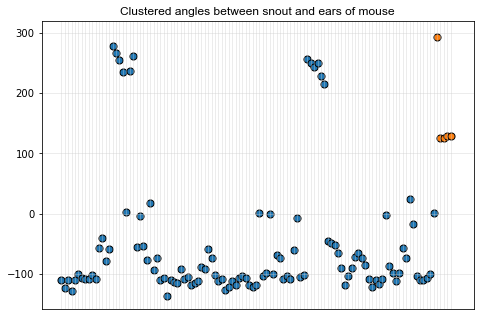

In [125]:
# Plot clusters and outliers
fig = plt.figure()

ax = fig.add_axes([.1,.1,1,1])

ax.scatter(clusters_df.index,clusters_df, edgecolors='black',s=50)
ax.scatter(outliers_df.index,outliers_df, edgecolors='black',s=50)

plt.title('Clustered angles between snout and ears of mouse', family='Arial',fontsize=12)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False) 

plt.grid(which='major',color='#cccccc', alpha=0.45)

'''
for row in outliers_df.iterrows():
    string = "".join(re.findall(r'\d',row[0]))
    id = string[3:]
    plt.text(row[0], row[1]*(1.015), str(id))
'''
# outliers should be positive values and not just random values on the right
plt.show()

### K-means clustering algorithm

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
%matplotlib inline

In [131]:
from FunctionsLib import distance_keypoints,clean_dataset

df = pd.read_hdf(r'openfield-Pranav-2018-08-20\labeled-data\m1s1\CollectedData_Pranav.h5')
dist = distance_keypoints(df,'snout','tailbase')

# check if there are any NaN values 
nan_rows = df[df.isna().any(axis=1)] 
#print(nan_rows) 

data = pd.DataFrame(data=dist, index=df.index, columns=None)
data = clean_dataset(data)
data.columns = ['distance snout-tailbase']
data.head()
data.describe()
#print(data)
#df.plot()

,distance snout-tailbase
count,115.000000
mean,108.092897
std,27.555520
min,14.698997
25%,104.784338
50%,111.365730
75%,124.836466
max,155.683007


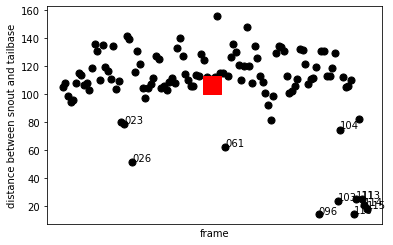

In [132]:
plt.scatter(data.index, data, s = 50, c = 'black')
plt.scatter(56, 106.92189147, s=300, c='r', marker='s')

for row in data.iterrows():
    if float(row[1]) < 80: #kind of a random treshold based on the data, need to find better
        string = "".join(re.findall(r'\d',row[0]))
        id = string[3:]
        plt.text(row[0], row[1]*(1.015), str(id))

plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False) 
plt.ylabel('distance between snout and tailbase')
plt.xlabel('frame') 

plt.show()

In [50]:
# defining the kmeans function
kmeans = KMeans(n_clusters=1)

# fitting the k means algorithm on data
kmeans.fit(data)
y_kmeans = kmeans.predict(data)

In [51]:
#kmeans.inertia_
kmeans.cluster_centers_

array([[106.92189147]])

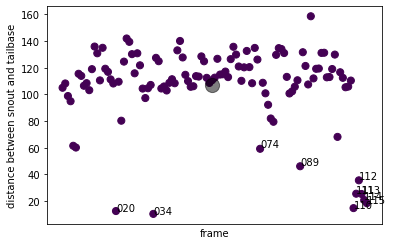

In [54]:
plt.scatter(data.index, data, c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False) 
plt.ylabel('distance between snout and tailbase')
plt.xlabel('frame')
plt.scatter(56, centers, c='black', s=200, alpha=0.5)
for row in data.iterrows():
    if float(row[1]) > 170 or float(row[1] < 60): #kind of a random treshold based on the data, need to find better
        string = "".join(re.findall(r'\d',row[0]))
        id = string[3:]
        plt.text(row[0], row[1]*(1.015), str(id))
plt.show()

Text(0, 0.5, 'Inertia')

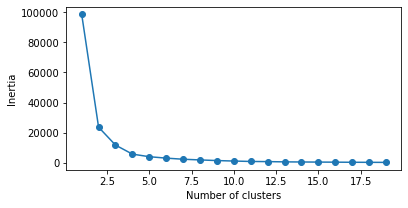

In [55]:
# fitting multiple k-means algorithms and storing the values in an empty list
SSE = []
for cluster in range(1,20):
    kmeans = KMeans(n_clusters = cluster, init='k-means++')
    kmeans.fit(data)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(6,3))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [56]:
# k means using 3 clusters and k-means++ initialization
kmeans = KMeans(n_clusters = 3, init='k-means++')
kmeans.fit(data)
pred = kmeans.predict(data)

In [57]:
frame = pd.DataFrame(data)
frame['cluster'] = pred
frame['cluster'].value_counts()

2    61
1    41
0    13
Name: cluster, dtype: int64



### K-means clustering algorithm: distances between all keypoints

In [191]:
df = pd.read_hdf(r'openfield-Pranav-2018-08-20\labeled-data\m1s1\CollectedData_Pranav.h5')

dist_st = distance_keypoints(df,'snout','tailbase')
dist_sr = distance_keypoints(df,'snout','rightear')
dist_sl = distance_keypoints(df,'snout','leftear')
dist_rt = distance_keypoints(df,'rightear','tailbase')
dist_lt = distance_keypoints(df,'leftear','tailbase')

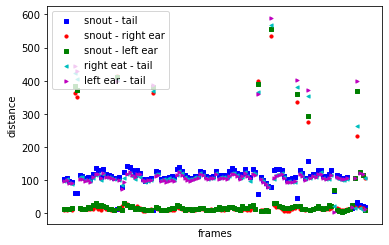

In [63]:
x = range(100)
y = range(100,200)
fig = plt.figure()
ax1 = fig.add_subplot(111)

plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False) 

ax1.scatter(df.index, dist_st, s=10, c='b', marker="s", label='snout - tail')
ax1.scatter(df.index, dist_sr, s=10, c='r', marker="o", label='snout - right ear')
ax1.scatter(df.index, dist_sl, s=10, c='g', marker="s", label='snout - left ear')
ax1.scatter(df.index, dist_rt, s=10, c='c', marker="<", label='right eat - tail')
ax1.scatter(df.index, dist_lt, s=10, c='m', marker=">", label='left ear - tail')
plt.legend(loc='upper left');
plt.ylabel('distance')
plt.xlabel('frames')

plt.show()

In [182]:
### using distance between the keypoints (a 4x4 matrix) then reshape them to a 1-d vector as our input of clustering
# SR = snout - right ear, SL = snout - left eat, RT = right ear - tail, LT = left ear - tail

from FunctionsLib import clean_dataset

data = pd.DataFrame(zip(dist_sr,dist_sl,dist_rt,dist_lt),columns=['SR','SL','RT','LT'])
data = clean_dataset(data)

clean_data = clean_dataset(data)
from_snout = clean_data[['SR', 'SL']].to_numpy()
from_tail = clean_data[['RT', 'LT']].to_numpy()

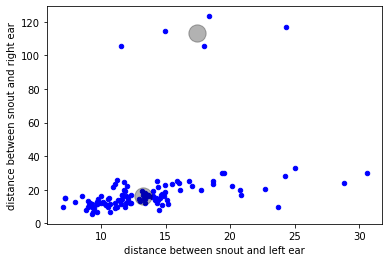

In [183]:
plt.scatter(from_snout[:,0], from_snout[:,1], s = 20, c = 'b')

plt.ylabel('distance between snout and right ear')
plt.xlabel('distance between snout and left ear')

plt.scatter(17.4420162,  113.15103566, c='black', s=300, alpha=0.3)
plt.scatter(13.28693934,  15.97122305, c='black', s=300, alpha=0.3)

plt.show()

In [189]:
# defining the kmeans function
kmeans = KMeans(n_clusters=4)

# fitting the k means algorithm on data
kmeans.fit(data[['SR', 'SL']])
y_kmeansrl = kmeans.predict(data[['SR', 'SL']])
print(y_kmeansrl)

[0 0 0 0 0 0 0 0 0 3 0 3 2 3 3 3 3 0 0 0 0 0 0 2 2 3 3 0 3 0 0 0 0 0 0 3 0
 0 0 0 0 0 0 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 3 3 0 0 0 3 0 0 3 3 0
 0 0 0 0 0 2 2 2 3 3 0 0 0 3 3 3 3 0 0 0 0 0 0 3 0 0 0 3 3 3 0 0 0 0 0 1 1
 1 1 1]


In [190]:
centers = kmeans.cluster_centers_
print(centers)

[[ 11.58657984  12.78452554]
 [ 17.4420162  113.15103566]
 [ 24.60192184  29.14647593]
 [ 15.41683461  21.68375149]]


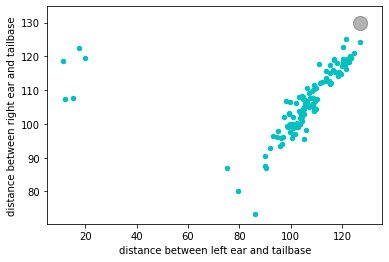

In [196]:
plt.scatter(from_tail[:,0], from_tail[:,1], s = 20, c = 'c')
plt.scatter(126.97166819, 130.03207587, c='black', s=200, alpha=0.3)

plt.ylabel('distance between right ear and tailbase')
plt.xlabel('distance between left ear and tailbase')

plt.show()

In [71]:
# defining the kmeans function
kmeans = KMeans(n_clusters=1)

# fitting the k means algorithm on data
kmeans.fit(data[['RT', 'LT']])
y_kmeans = kmeans.predict(data[['RT', 'LT']])

centers = kmeans.cluster_centers_
print(centers)

[[126.97166819 130.03207587]]


In [73]:
d = clean_data.to_numpy().flatten()
d = d.reshape(-1, 1)

# defining the kmeans function
kmeans = KMeans(n_clusters=4)

# fitting the k means algorithm on data
kmeans.fit(d)
y_kmeans = kmeans.predict(d)

centers = kmeans.cluster_centers_
print(centers)

[[ 14.59433056]
 [374.96231869]
 [107.71557272]
 [562.06933392]]


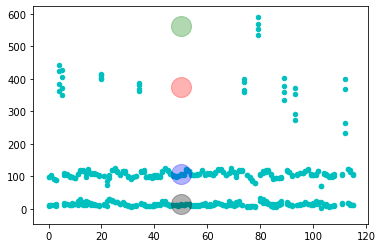

In [75]:
plt.scatter(np.repeat(np.array(clean_data.index),4), d, s = 20, c = 'c')

plt.scatter(50, 14.59433056, c='black', s=400, alpha=0.3)
plt.scatter(50, 374.96231869, c='red', s=400, alpha=0.3)
plt.scatter(50, 107.71557272, c='blue', s=400, alpha=0.3)
plt.scatter(50, 562.06933392, c='green', s=400, alpha=0.3)

plt.show()

### nice to compare with the correct values clustered

110.69569261997655 --> the true mean of distance between snout and tailbase (computed thanks to dist_st
computed with the labeled-data-correct

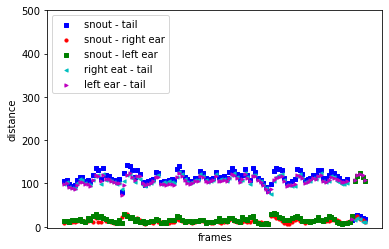

In [88]:
df = pd.read_hdf(r'openfield-Pranav-2018-08-20\labeled-data-correct\m1s1\CollectedData_Pranav.h5')

dist_st = distance_keypoints(df,'snout','tailbase')
dist_sr = distance_keypoints(df,'snout','rightear')
dist_sl = distance_keypoints(df,'snout','leftear')
dist_rt = distance_keypoints(df,'rightear','tailbase')
dist_lt = distance_keypoints(df,'leftear','tailbase')

x = range(100)
y = range(100,200)
fig = plt.figure()
ax1 = fig.add_subplot(111)

plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False) 

ax1.scatter(df.index, dist_st, s=10, c='b', marker="s", label='snout - tail')
ax1.scatter(df.index, dist_sr, s=10, c='r', marker="o", label='snout - right ear')
ax1.scatter(df.index, dist_sl, s=10, c='g', marker="s", label='snout - left ear')
ax1.scatter(df.index, dist_rt, s=10, c='c', marker="<", label='right eat - tail')
ax1.scatter(df.index, dist_lt, s=10, c='m', marker=">", label='left ear - tail')
plt.legend(loc='upper left');
plt.ylabel('distance')
plt.xlabel('frames')
ax1.set_ylim(ymax=500)

plt.show()

In [177]:
from FunctionsLib import clean_dataset

data = pd.DataFrame(zip(dist_sr,dist_sl,dist_rt,dist_lt),columns=['SR','SL','RT','LT'])
data = clean_dataset(data)

clean_data = clean_dataset(data)
from_snout = clean_data[['SR', 'SL']].to_numpy()
from_tail = clean_data[['RT', 'LT']].to_numpy()

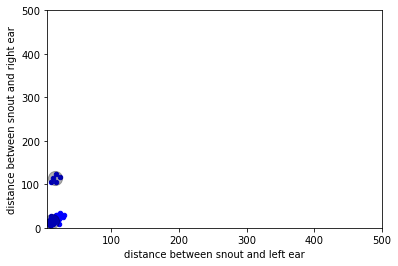

In [158]:
plt.scatter(from_snout[:,0], from_snout[:,1], s = 20, c = 'b')

plt.ylabel('distance between snout and right ear')
plt.xlabel('distance between snout and left ear')

plt.xlim(xmax=500)
plt.ylim(ymax=500)

plt.scatter(13.28693934,  15.97122305, c='black', s=200, alpha=0.3)
plt.scatter(17.4420162,  113.15103566, c='black', s=200, alpha=0.3)


# find a treshold at which it would be interesting to look at the frames to see if the labels are correct

plt.show()

In [155]:
# defining the kmeans function
kmeans = KMeans(n_clusters=2)

# fitting the k means algorithm on data
kmeans.fit(data[['SR', 'SL']])
y_kmeans = kmeans.predict(data[['SR', 'SL']])

centers = kmeans.cluster_centers_
print(centers)

[[ 13.28693934  15.97122305]
 [ 17.4420162  113.15103566]]


In [173]:
from sklearn.metrics.cluster import rand_score,adjusted_rand_score
print(rand_score(y_kmeans, y_kmeansrl))
print(adjusted_rand_score(y_kmeans,y_kmeansrl))

1.0
1.0


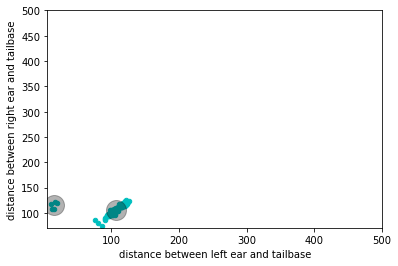

In [181]:
plt.scatter(from_tail[:,0], from_tail[:,1], s = 20, c = 'c')
plt.scatter(107.1991587,  106.41819271, c='black', s=400, alpha=0.3)
plt.scatter( 15.16394037, 115.09471555, c='black', s=400, alpha=0.3)

plt.ylabel('distance between right ear and tailbase')
plt.xlabel('distance between left ear and tailbase')

plt.xlim(xmax=500)
plt.ylim(ymax=500)

plt.show()

In [179]:
# defining the kmeans function
kmeans = KMeans(n_clusters=2)

# fitting the k means algorithm on data
kmeans.fit(data[['RT', 'LT']])
y_kmeans = kmeans.predict(data[['RT', 'LT']])

centers = kmeans.cluster_centers_
print(centers)

[[107.1991587  106.41819271]
 [ 15.16394037 115.09471555]]


In [92]:
%store -r swapped_frames 
#to get values from the other notebook (corruption-etc....)
#print(swapped_frames)

In [93]:
from sklearn import metrics